# Introduction to Variational Bayesian Methods
## David Schlueter
## Vanderbilt University Department of Biostatistics
### March 24, 2017

In Bayesian analysis, the most common strategy for computing posterior quantities is through Markov Chain Monte Carlo (MCMC). Despite recent advances in efficient sampling, MCMC methods still remain computationally intensive for more than a few thousand observations. A more scalable alternative to sampling is Variational Inference (VI), which re-frames the problem of computing the posterior distribution as a minimization of the Kullback-Leibler divergence between the true posterior and a member of some approximating family. 

In this talk, we provide a basic overview of the VI framework as well as practical examples of its implementation using the Automatic Differentiation Variational Inference (ADVI) engine in PyMC3. Notably, we'll generate a toy classification problem and walk through how to do it in PyMC3. If time allows, I'll show a more complicated example from my dissertation.

Examples used in this notebook are also contained in the PyMC3 documentation, notably [this doc](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html) by Thomas Wiecki.

## Basics of Variational Bayesian Methods 


For a more detailed overview, see [this paper](https://arxiv.org/abs/1601.00670).

Suppose we have data $\boldsymbol{x}$ that is dependent on some latent variables $\theta$. The inferential problem is to compute the conditional density of the latent variables given the 
observations, $p(\theta | x)$. From this probability we can compute all sorts of useful quantities. Conditional probability gives us 

\begin{equation}
p(\theta|x) = \frac{p(\theta,x)}{p(x)}
\end{equation}

Where 
\begin{equation}
p(x) = \int p(\theta,x) d\theta,
\end{equation}

Which is the log density of the data, often called the "model evidence."
- This quantity is often unavailable in closed form and is the main source of computational headache, hearbreak, and frustration. 


As an alternative to sampling from an ergodic Markov Chain, Variational Bayes is an inferential method that approximates the posterior distribution through the minimization of the relative entropy (or in general some other operator). For an arbitrary posterior distribution $p(\theta|x)$, and some approximating family $q(z)$, the variational objective is defined by 

\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi}KL(q(\theta; \phi) || p(\theta|X))
\end{equation}


\begin{eqnarray*}
\log p(x)&=&\log\int p(x,\theta)d\theta\\
&=&\log\int p(x,\theta)\frac{q(\theta)}{q(\theta)}d\theta\\
&=&\log(E_{q}\left[\frac{p(x,\theta)}{q(\theta)}\right])\\
&\geq& E_q[\log p(x,\theta)]-E_q[\log q(\theta)].
\end{eqnarray*}

The quantity in the final line is known as the evidence lower bound (ELBO). Now, we see that the KL divergence is given by

\begin{eqnarray}
KL(q|p)&=&E_q\left[\log\frac{q(\theta)}{p(\theta|x)}\right]\\
&=&E_q[\log q(\theta)]-E_q[\log p(\theta|x)]\\
&=&E_q[\log p(\theta,x)]-E_q[\log q(\theta)]+\log p(x). 
\end{eqnarray}

We can see that the KL divergence is given by the sum of the ELBO and Model Evidence. What this implies for a computational solution is that minimizing the KL divergence is accomplished by maximizing the evidence lower bound.

So, which variational family for z do we use? Most common is the \emph{mean-field} variational family where the latent variables are
mutually independent and each governed by a distinct factor in the variational density. A
generic member of the mean-field variational family is given by 

\begin{equation}
q(\theta) = \prod_{j=1}^m q_j(\theta_j)
\end{equation}

This is a restrictive approximation, but full rank alternatives are available. 



## Computation:
A natural question at this point is how does one implement the optimization of the objective function? Traditionally, one would have to tediously derive updates (similarly to EM) for every model separately. Even for very modest models, this involves many pages of algebra. 

However, recent advances in the Machine Learning world have allowed for automatic computation of VI. 

### [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788)
With ease of computation in mind, Kucukelbir et. al. 2015 developed a way to perform VI automatically. Without going into too much detail (see reference for details), the authors proposed transforming the problem in a series of steps:

1. Specify the joint model, $p(x,\theta)$
2. Transform model into surrogate containing unconstrained real-valued latent variables, $\zeta$. $p(x,\theta) \to p(x,\zeta)$
    - Variational inference is then performed on the transformed model. New objective: 
    
$$
\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi} KL(q(\zeta; \phi)||p(\theta|\zeta))
\end{equation}
$$
    - all latent variables are defined on the same space. ADVI can now use a single variational family for all
     models
3. Recast the variational objective as an expectation over the the approximating distribution $q$ using the . 
3. ADVI recasts the gradient of the variational objective function as an expectation over q. This allows for the use of Monte Carlo integration to perform the optimization
4. Next, the framework transforms the problem again and re-casts the gradient in terms of a standard Gaussian distribution. This makes MC integration very efficient since sampling is done from $N(0,1)$
5. Compute noisy gradients to optimize the objective. 


ADVI has complexity $O(2NMK)$ per iteration, where $M$ is the number of Monte Carlo samples
(typically between 1 and 10). 

### Example: Bayesian Neural Network

For an in depth introduction to Neural Networks, see Chris Fonnesbeck's notebook [here](https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section6_7-Neural-Networks.ipynb)

In [1]:
#### Examples:
%matplotlib inline
from matplotlib import pyplot as plt
import pymc3 as pm
from pymc3 import Gamma, Poisson, Normal, Model, sample, forestplot, NUTS, Metropolis, find_MAP, starting, traceplot
import theano.tensor as tt
from theano import function as fn
from theano import printing
import numpy as np
import scipy as sp
import pandas as pd
import random

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

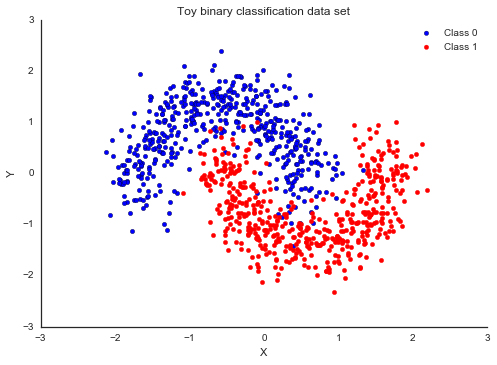

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

We first define the model. Since, PyMC3 uses Theano as a back end, functions need to be compiled first. 

In [5]:
# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                             shape=(X.shape[1], n_hidden),
                             testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                              shape=(n_hidden,),
                              testval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1,
                                     weights_1_2))
    act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                          weights_2_out))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out',
                       act_out,
                       observed=ann_output)

Now we run the ADVI routine.

In [6]:
%%time
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Average ELBO = -146.81: 100%|██████████| 50000/50000 [00:18<00:00, 2741.11it/s]

CPU times: user 21.2 s, sys: 836 ms, total: 22.1 s
Wall time: 23.7 s


Once the optimization has been performed, we simply sample from the approximating distribution.

In [9]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:00<00:00, 7778.11it/s]


We can see the optimization course by plotting the ELBO values over time.

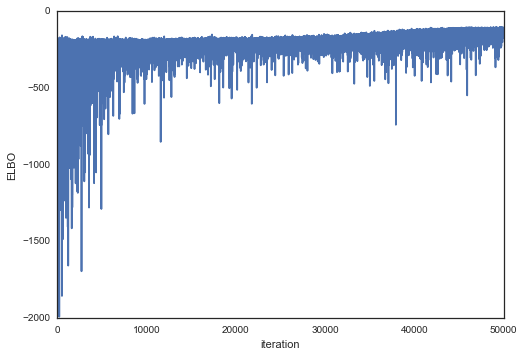

In [13]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

Of course, we can predict new values...

In [15]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:03<00:00, 141.17it/s]


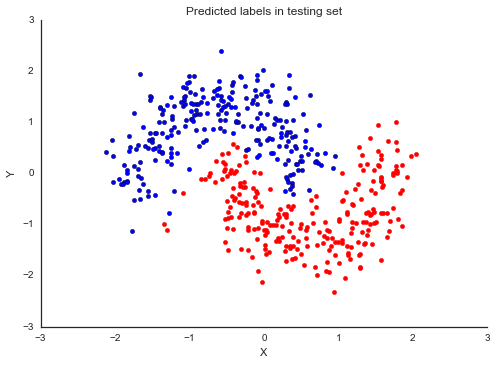

In [16]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [17]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))


Accuracy = 96.39999999999999%


In [18]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [19]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)


100%|██████████| 500/500 [00:05<00:00, 87.40it/s]


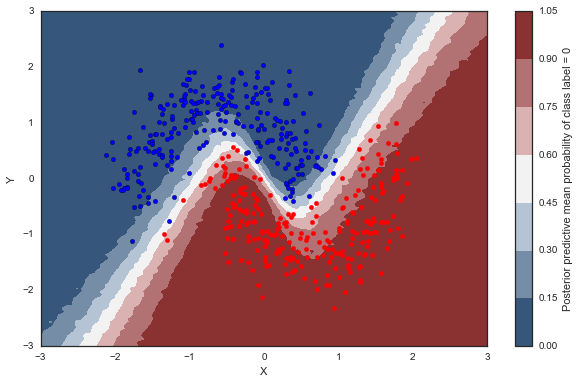

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

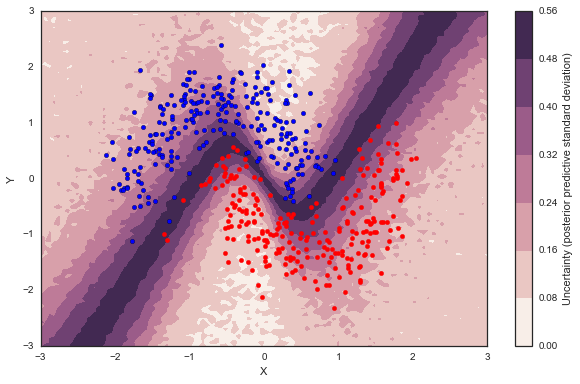

In [21]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### Mini-Batch ADVI

- Instead of using the full dataset at once, we can visit subsamples of the data of size $B<<N$. This reduces complexity of the algorithm to a per-iteration complexity $O(2BMK)$.
- Mini-batch is considered best practice
     - Helps protect against getting stuck in local minima
     - Faster convergence 
- Set up in PyMC is relatively straightforward.
    1. Define Tensors for data
    2. Specify PyMC3 model in terms of these tensors
    3. Create generator for sampling of data
    4. Run ADVI-Minibatch function

In [22]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train),
    create_minibatch(Y_train),
)

total_size = len(Y_train)

In [23]:
%%time
with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors,
        minibatch_RVs=minibatch_RVs, minibatches=minibatches,
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Average ELBO = -115.58: 100%|██████████| 50000/50000 [00:18<00:00, 2634.85it/s]

CPU times: user 25.5 s, sys: 1.95 s, total: 27.5 s
Wall time: 41 s


In [24]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:00<00:00, 7541.18it/s]


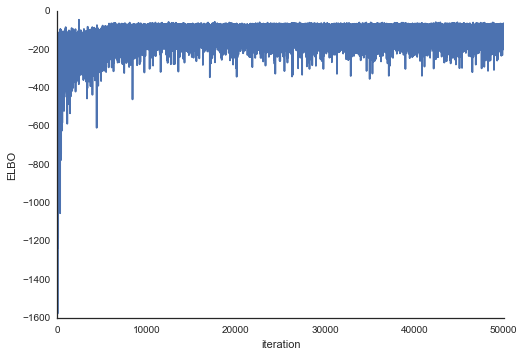

In [25]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

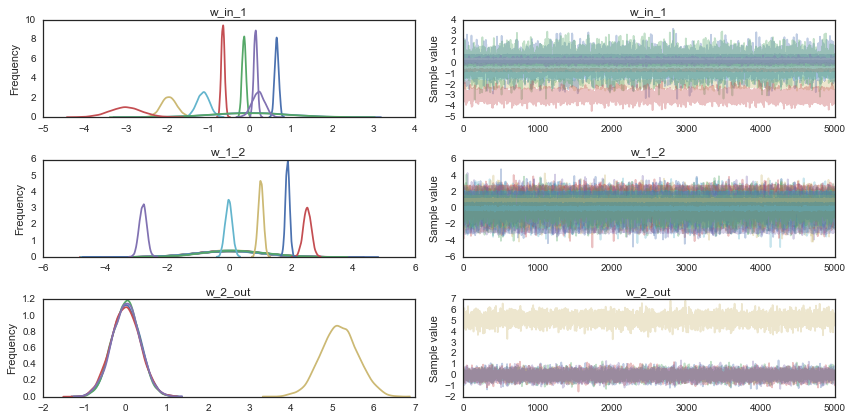

In [26]:
pm.traceplot(trace);


### References: 
    1. [Automatic Differentiation Variational Inference. Kucukelbir, A., Tran D., Ranganath, R., Gelman, A., and Blei, D. M. (2016)](https://arxiv.org/abs/1603.00788)
    2. [Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe (2016)] (https://arxiv.org/abs/1601.00670)